<a href="https://colab.research.google.com/github/DmitriySechkin/ds-learning-sb/blob/main/cv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [3]:
# архитектура модели +
# загрузчик данных +
# формирование батча +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [2]:
train_dataset = datasets.MNIST('.', download=True)
test_dataset = datasets.MNIST('.', download=True, train=False)

In [ ]:
len(train_dataset)

60000

In [ ]:
len(test_dataset)

10000

In [ ]:
test_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 7)

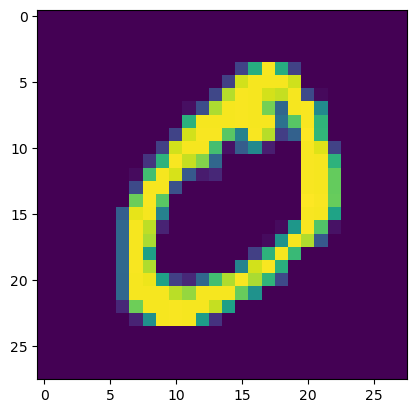

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.data[1].detach().numpy())
plt.show()

In [6]:
class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, hidden_dim)
    # self.linear4 = nn.Linear(hidden_dim, int(hidden_dim / 2))
    # self.linear5 = nn.Linear(hidden_dim, output_dim)

    self.bn1 = nn.BatchNorm1d(hidden_dim)
    self.bn2 = nn.BatchNorm1d(hidden_dim)
    self.bn3 = nn.BatchNorm1d(hidden_dim)
    # self.bn4 = nn.BatchNorm1d(int(hidden_dim / 2))

    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.do3 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.bn1(self.linear1(x))))
    x = self.do2(self.activation(self.bn2(self.linear2(x))))
    x = self.do3(self.activation(self.bn3(self.linear3(x))))
    # x = self.do3(self.activation(self.bn4(self.linear4(x))))

    return self.linear5(x)

In [7]:
def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []

  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])

  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }


In [8]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 20
batch_size = 128
learning_rate = 0.001

In [9]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

In [4]:
def train_model(train_dataloader, model):
  train_loss = 0

  model.train()

  for i, batch in enumerate(train_dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())

    loss.backward()
    optim.step()

    train_loss += loss.item()

  return train_loss

In [5]:
def validate_model(test_dataloader, model):
  test_loss = 0

  model.eval()

  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
      predict = model(batch['data'].to(device))
      target = batch['target'].to(device).long()
      loss = loss_func(predict, target)

      test_loss += loss.item()

  return test_loss

In [6]:
def compute_accuracy(model, dataloader):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['data'], batch['target']
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
train_losses = []
test_losses = []


for epoch in range(n_epochs):
  train_loss = 0
  test_loss = 0

  train_dataloader = DataLoader(train_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn,
                          drop_last = True,
                          )

  test_dataloader = DataLoader(test_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn,
                          drop_last = True,
                          )

  train_loss += train_model(train_dataloader, model)
  test_loss += validate_model(test_dataloader, model)

  train_losses.append(train_loss / len(train_dataloader))
  test_losses.append(test_loss / len(test_dataloader))

  print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {test_losses[-1]:.4f}')

  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')

print(f'minimum loss - {min(test_losses):.4f}')


Epoch [1/20], Train Loss: 0.2248, Val Loss: 0.1002
Epoch [2/20], Train Loss: 0.1000, Val Loss: 0.0810
Epoch [3/20], Train Loss: 0.0742, Val Loss: 0.0783
Epoch [4/20], Train Loss: 0.0596, Val Loss: 0.0684
Epoch [5/20], Train Loss: 0.0498, Val Loss: 0.0641
Epoch [6/20], Train Loss: 0.0433, Val Loss: 0.0629
Epoch [7/20], Train Loss: 0.0385, Val Loss: 0.0599
Epoch [8/20], Train Loss: 0.0337, Val Loss: 0.0621
Epoch [9/20], Train Loss: 0.0313, Val Loss: 0.0571
Epoch [10/20], Train Loss: 0.0276, Val Loss: 0.0657
Epoch [11/20], Train Loss: 0.0263, Val Loss: 0.0557
Epoch [12/20], Train Loss: 0.0231, Val Loss: 0.0609
Epoch [13/20], Train Loss: 0.0228, Val Loss: 0.0575
Epoch [14/20], Train Loss: 0.0204, Val Loss: 0.0658
Epoch [15/20], Train Loss: 0.0192, Val Loss: 0.0616
Epoch [16/20], Train Loss: 0.0183, Val Loss: 0.0648
Epoch [17/20], Train Loss: 0.0170, Val Loss: 0.0568
Epoch [18/20], Train Loss: 0.0152, Val Loss: 0.0556
Epoch [19/20], Train Loss: 0.0166, Val Loss: 0.0604
Epoch [20/20], Train 

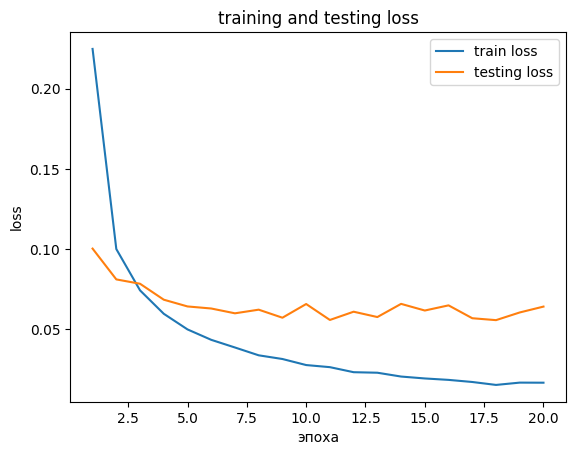

In [ ]:
plt.plot(range(1, n_epochs+1), train_losses, label='train loss')
plt.plot(range(1, n_epochs+1), test_losses, label='testing loss')
plt.xlabel('эпоха')
plt.ylabel('loss')
plt.title('training and testing loss')
plt.legend()
plt.show()

In [13]:
train_dataloader = DataLoader(train_dataset,
                              batch_size,
                              shuffle=False,
                              collate_fn=collate_fn)

test_dataloader = DataLoader(test_dataset,
                             batch_size,
                             shuffle=False,
                             collate_fn=collate_fn)

In [ ]:


train_accuracy = compute_accuracy(model, train_dataloader)
test_accuracy = compute_accuracy(model, test_dataloader)

print(f'train accuracy - {train_accuracy:.4f}')
print(f'test accuracy - {test_accuracy:.4f}')

train accuracy - 0.9987
test accuracy - 0.9840


Без batchnorm потери на валидации перестали снижаться где-то в районе 4-5 эпохи. При этом потери обучения продолжали снижаться до 20-й эпохи. Скорее всего модель на количестве эпох больше 10-15 (в зависимости от lr) начинает переобучаться и обучать на большем количестве эпох нет смысла.

При применении batchnorm потери на валидации (видно на графике) снижаются где-то до 10-й эпохи, дальше уже график начинает колебаться, но при этом минимальное значение loss достигается на 18-й эпохе

Добавление слоев больше 4-х привело к ухудшению производительности модели и не уменьшило loss на валидации. Изменение lr в меньшую сторону приводит только к тому, что модель дольше обучается (сходится за большее количество эпох), график уменьшения loss более плавный, к уменьшению самого loss это не привело. Изменение других параметров таких как количество нейронов в разных слоях и batch size так же не привело к значимому эффекту по loss

# Сверточные сети


In [111]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch,
                           kernel_size=5, padding=2, stride=2) # уменьшаем картинку в 2 раза
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.conv5 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn5 = nn.BatchNorm2d(hidden_ch)
    self.conv6 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn6 = nn.BatchNorm2d(hidden_ch)
    self.conv4 = nn.Conv2d(hidden_ch, 10, kernel_size=3, padding=1)
    self.bn4 = nn.BatchNorm2d(10)
    self.linear3 = nn.Linear(10 * 14 * 14, output_dim)

    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.do3 = nn.Dropout(dropout_p)
    self.do5 = nn.Dropout(dropout_p)
    self.do6 = nn.Dropout(dropout_p)

    self.activation = nn.ReLU()
    
    # self.apply(self.initialize_weights)

  def initialize_weights(self, m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

  def forward(self, x):
    x = self.do1(self.activation(self.bn1(self.conv1(x))))
    x = self.do2(self.activation(self.bn2(self.conv2(x))))
    x = self.do3(self.activation(self.bn3(self.conv3(x))))
    x = self.do5(self.activation(self.bn5(self.conv5(x))))
    x = self.do6(self.activation(self.bn6(self.conv6(x))))
    x = self.activation(self.bn4(self.conv4(x))) # B x 2 x 14 x 14


    return self.linear3(x.view(x.size(0), -1))
    # x.size() -> (B, W, H); x.size(0) -> B
    # x.view(B, -1) -> (B, вектор размера всего остального)

In [8]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []

  for item in data:
    pics.append(numpy.array(item[0])) # W x H
    target.append(item[1])

  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1(C) x W x H
      'target': target.long(),
      }


In [93]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 14
batch_size = 128 
learning_rate = 0.0001

In [112]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

In [113]:
train_losses = []
test_losses = []

for epoch in range(n_epochs):
  train_loss = 0
  test_loss = 0

  train_dataloader = DataLoader(train_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )

  test_dataloader = DataLoader(test_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )

  train_loss += train_model(train_dataloader, model_conv)
  test_loss += validate_model(test_dataloader, model_conv)

  train_losses.append(train_loss / len(train_dataloader))
  test_losses.append(test_loss / len(test_dataloader))

  print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {test_losses[-1]:.4f}')

  torch.save(model_conv.state_dict(), f'./chkpt_{epoch}.pth')

print(f'{min(test_losses):.4f}')


Epoch [1/14], Train Loss: 0.3461, Val Loss: 0.0586
Epoch [2/14], Train Loss: 0.0592, Val Loss: 0.0384
Epoch [3/14], Train Loss: 0.0398, Val Loss: 0.0242
Epoch [4/14], Train Loss: 0.0306, Val Loss: 0.0219
Epoch [5/14], Train Loss: 0.0251, Val Loss: 0.0200
Epoch [6/14], Train Loss: 0.0216, Val Loss: 0.0281
Epoch [7/14], Train Loss: 0.0185, Val Loss: 0.0195
Epoch [8/14], Train Loss: 0.0158, Val Loss: 0.0182
Epoch [9/14], Train Loss: 0.0133, Val Loss: 0.0148
Epoch [10/14], Train Loss: 0.0128, Val Loss: 0.0169
Epoch [11/14], Train Loss: 0.0112, Val Loss: 0.0182
Epoch [12/14], Train Loss: 0.0096, Val Loss: 0.0170
Epoch [13/14], Train Loss: 0.0082, Val Loss: 0.0148
Epoch [14/14], Train Loss: 0.0074, Val Loss: 0.0146
0.0146


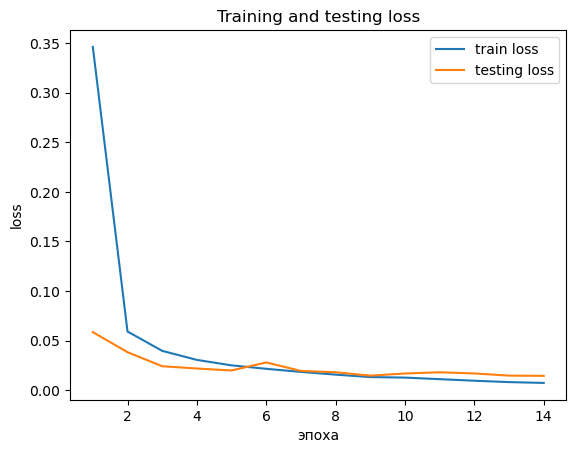

In [114]:
plt.plot(range(1, n_epochs+1), train_losses, label='train loss')
plt.plot(range(1, n_epochs+1), test_losses, label='testing loss')
plt.xlabel('эпоха')
plt.ylabel('loss')
plt.title('Training and testing loss')
plt.legend()
plt.show()

In [46]:
def compute_accuracy_conv(model, dataloader):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['data'].to(device), batch['target'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [115]:
train_dataloader = DataLoader(train_dataset,
                              batch_size,
                              shuffle=False,
                              collate_fn=collate_fn_conv)

test_dataloader = DataLoader(test_dataset,
                             batch_size,
                             shuffle=False,
                             collate_fn=collate_fn_conv)

In [116]:
train_accuracy = compute_accuracy_conv(model_conv, train_dataloader)
test_accuracy = compute_accuracy_conv(model_conv, test_dataloader)

print(f'train accuracy - {train_accuracy:.4f}')
print(f'test accuracy - {test_accuracy:.4f}')

train accuracy - 0.9994
test accuracy - 0.9948


Увеличение количества hidden_channels привело к увеличению времени обучения модели и к падению качества модели. Добавление слоев сверки позволило повысить качество модели. Снижение lr делает график потерь на валидации более плавным. Без инициализации весов модель показала более высокий результат. 

В целом сверточная нейросеть отработала лучше линейной. 